In [1]:
from qiskit import QuantumCircuit, Aer
from qiskit_experiments.library import StateTomography
from qiskit.visualization import array_to_latex, plot_state_city

In [2]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

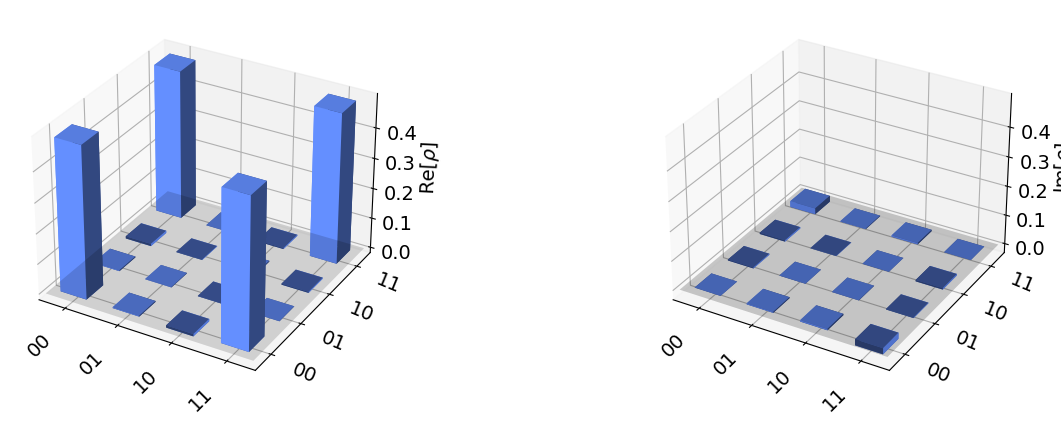

In [3]:
st = StateTomography(qc)
backend = Aer.get_backend('aer_simulator')
stdata = st.run(backend, shots=1000).block_for_results()
state_result = stdata.analysis_results("state")
# array_to_latex(state_result.value)
plot_state_city(state_result.value)
